# Table of Contents
* [Assignment 5: Control a Marble with Reinforcement Learning](#Assignment-5:-Control-a-Marble-with-Reinforcement-Learning)
	* [Overview](#Overview)
    * [Results](#Results)  
        * [Initial Trial](#Initial-Trial)

$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

Daniel Ball

## Overview

Supplied code was modified to take the goal as a parameter, allowing the network to train to different positions on the "slider". In addition to adding the code, the input to the neural network was modified so that it accommodates the new size input. If no goal is provided as a parameter, a random goal is chosen. For training, rather than a single goal we need a random goal. To this end, initialState() will select a random goal and nextState() will retain the goal. This way the network should have time to "discover" the correct response for various starting positions, velocities, and goals. Because we have added a dimension to the input data, it can be expected that more trials will be required in order to have a useful model.

In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

To define a reinforcement learning problem, we need functions that return

* initial the state of the environment,
* a next state given a current state and an action,
* a reinforcement value, and
* an action to take, given the current state. For this we define an $\epsilon$-greedy policy.
* the goal to move the marble to

Let's first define the set of valid actions.  For our simple one-dimensional marble problem, we can push left, right, or not push at all.

In [2]:
validActions = np.array([ -1, 0, 1])

def initialState(goal=None):
    if goal is None:
        goal = np.random.randint(0,11)        
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()), goal])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0, s[2]])
    elif s[0] > 10:
        s = np.array([10,0, s[2]])
    return s

def reinforcement(s):  # s is new state
    return 0 if abs(s[0]-s[2]) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        partA = np.tile(state, (validActions.shape[0], 1))
        partB = validActions.reshape((-1,1))
        inputs = np.hstack((partA, partB ))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

In [3]:
# testing initialState()
# should be different values for all indices each time
for i in range(3):
    state = initialState()
    print(state)

[ 3.9368351   1.18391115  6.        ]
[ 9.74236476 -0.64054491  3.        ]
[ 9.61645545  0.46542602  1.        ]


In [4]:
# testing nextState()
# goal should remain constant
print(nextState([7,3,5], -1))
print(nextState([-1,3,5], -1))
print(nextState([11,3,5], -1))

[7.3, 2.74, 5]
[0 0 5]
[10  0  5]


Now we need a function to generate a bunch of samples that are interactions with the marble.

In [5]:
def makeSamples(qnet, nStepsPerStart, goal=None):
    samples = []
    state = initialState(goal)
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

Now we can play.  Define constants we need.

In [6]:
def plotRandomAction(trial, epsilonTrace):
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Probability ($\epsilon$)")
    plt.ylim(0,1)    
    plt.xlabel("trial")
    plt.title("Random Action Probability")

In [7]:
def plotMarbleMotion(X):
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [X[0][2],X[0][2]],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.xlabel("step")
    plt.ylim(-1,11)
    plt.title("Marble Position over Time for goal=" + str(X[0][2]))

In [8]:
def plotPolicy(qs):
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    

In [9]:
def plotMeanReinforcement():
    plt.plot(rtrace[:trial+1],alpha=0.5)
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.xlabel("trial")
    plt.title("Reinforcement Trend")

In [10]:
def plotPosition(X):
    goal = X[0][2]
    fillMin = max(goal-1, 0)
    fillMax = min(goal + 1, 10)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([fillMin,fillMax],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    plt.title("Marble Path for goal=" + str(goal))

In [11]:
def plotQMaxContour(xs,ys,qsmax):
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q (Contour Plot)")

In [12]:
def plotActionContour(xs,ys,qs, acts):
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Action (Contour Plot)")

In [13]:
 def plotQMaxSurface(s, xs, ys,qsmax):
    s.axis('off') # turn off that ugly box around the plot
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    plt.title("Max Q (Surface Plot)")

In [14]:
def plotActionSurface(s,xs,ys,acts):
    s.axis('off') # turn off that ugly box around the plot    
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    plt.title("Action (Surface Plot)")

In [15]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace):
    goal = X[0][2]
    
#     makePlot(qnet, X, R, trial, epsilonTrace, rtrace)
    
    qs = qnet.use(np.array([[s,0, goal,a] for a in validActions for s in range(11)]))
    plt.subplot(4,3,1)
    plotRandomAction(trial,epsilonTrace)
    
    plt.subplot(4,3,2)
    plotMarbleMotion(X)
    
#     plt.subplot(4,3,3)
#     plotPolicy(qs)
    
    plt.subplot(4,3,4)
    plotMeanReinforcement()
    
    plt.subplot(4,3,5)
    plotPosition(X)    

In [16]:
def testIt(qnet,nTrials,nStepsPerTrial, goal=5):
    xs = np.linspace(0,10,nTrials)
    for x in xs:       
        s = [x,0, goal] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,3))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([goal,goal],[-5,5],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$, goal=' + str(goal))

## Results
This section contains results of training the new network and details progress toward a trained network. Each attempt is catalogued in two sections: progressive and trained. The progressive section displays the current state of the model as it is trained. In its final state, this section shows a rough history of the training process. Marble position, path, and trajectories are representative only for the goal assigned for the current trial or, in the case of a finalized model, the last trial to execute.

The trained section contains figures depicting the performance of the model on novel data when applied to the trained model. In particular: state trajectories for goals 0..10 as well as contour and surface plots for Max Q and Action for goals 1,5, and 9.

In [20]:
def plotProgress(qnet, X, R, trial):
     # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
        plt.subplot(4,3,3)
        testIt(qnet,10,500, goal=currentGoal)
        clear_output(wait=True)
        display(fig);
        plt.tight_layout()
        plt.pause(0.01)

In [40]:
def runTrial():
    fig = plt.figure(figsize=(15,15))

    epsilon = 1
    epsilonTrace = np.zeros(nTrials)
    rtrace = np.zeros(nTrials)    
    for trial in range(nTrials):
        # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        samples = makeSamples(qnet, nStepsPerTrial)

        ns = 3
        na = 1
        X = samples[:, :ns+na]
        currentGoal = X[0][2]
        R = samples[:, ns+na:ns+na+1]
        nextX = samples[:, ns+na+1:]
        nextQ = qnet.use(nextX)

        qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

        # Decay epsilon
        epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        #plot current model state
        plotProgress(qnet, X, R, trial)
    clear_output(wait=True)
    return qnet

In [59]:
# Plot Trajectories
def plotTrajectories(qnet):
    fig = plt.figure(figsize=(15,15))
    for currentGoal in range(0,11):
        plt.subplot(4,3,currentGoal+1)
        testIt(qnet,10,500, goal=currentGoal)
    plt.tight_layout()

In [61]:
def plotNN(qnet):
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])
    plt.title('Neural Network')  

In [74]:
def plotBehavior(qnet, goal):
    fig = plt.figure(figsize=(10,10))
    #prepare data for contour/surface
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat    
    qs = qnet.use(np.array([[xsflat[i],ysflat[i], goal,a] for a in validActions for i in range(len(xsflat))]))
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    
    plt.subplot(2,2,1)
    plotQMaxContour(xs,ys,qsmax)
    
    plt.subplot(2,2,2)
    plotActionContour(xs,ys,qs, acts)

    s = plt.subplot(2,2,3)
    plotQMaxSurface(s, xs, ys,qsmax)

    s = plt.subplot(2,2,4)
    plotActionSurface(s,xs,ys,acts)

### Initial Trial
A crude first try to see how the model trains by using a random goal for each trial.

##### Setup

In [79]:
gamma = 0.999
nTrials = 600
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0, 10), (-1,1)))

##### Execution

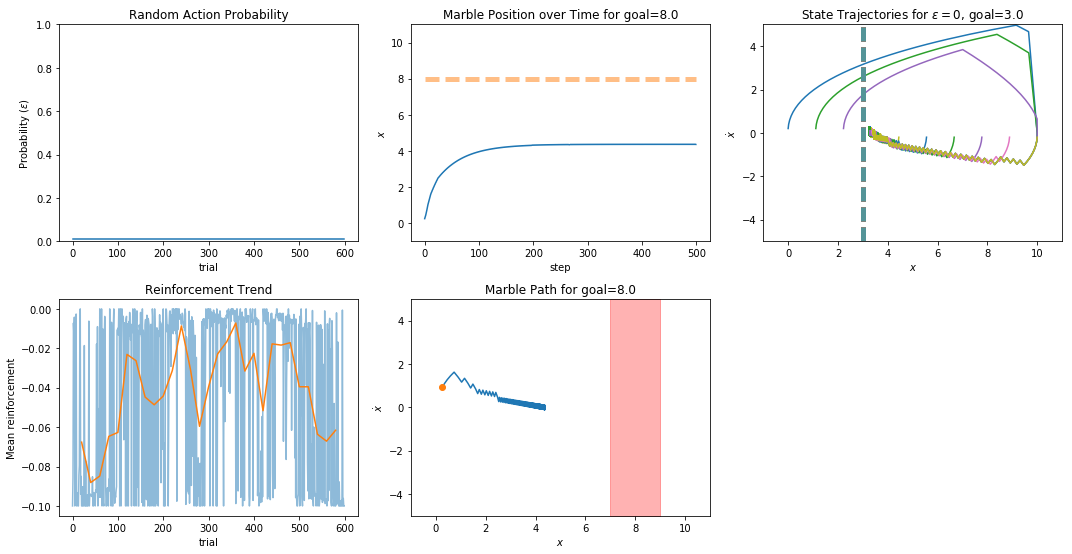

In [41]:
qnet = runTrial()

In [57]:
plotTrajectories(qnet)

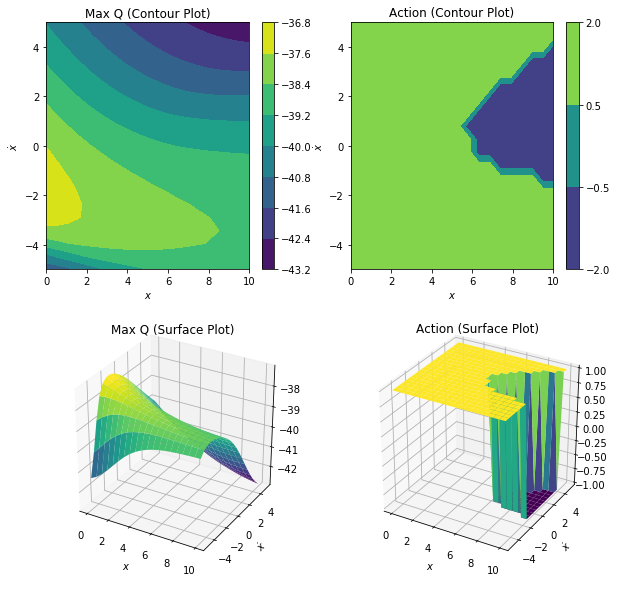

In [76]:
plotBehavior(qnet, goal=1)

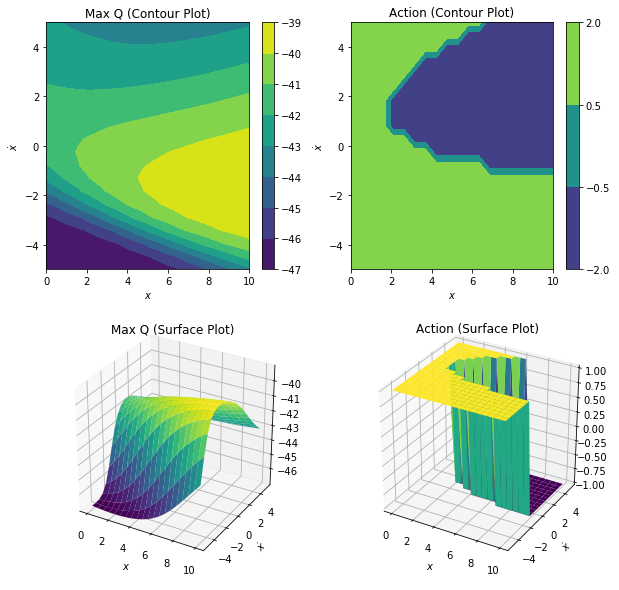

In [77]:
plotBehavior(qnet, goal=5)

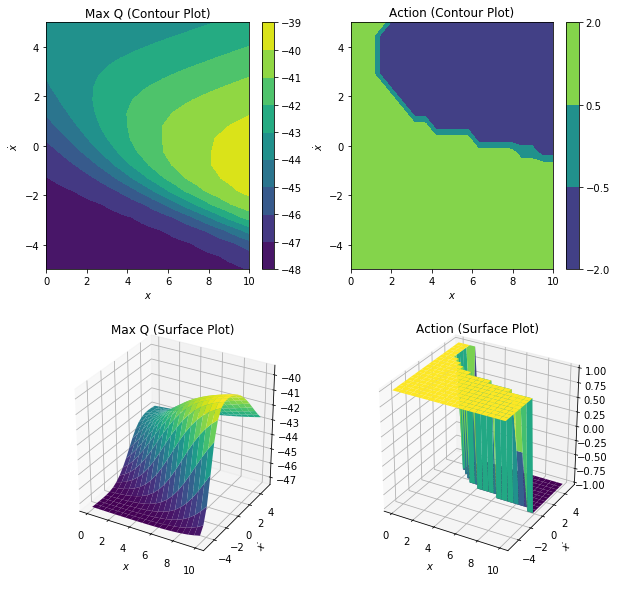

In [78]:
plotBehavior(qnet, goal=9)

#### Results and Analysis

Not super useful. For goals above 5, performance is OK and the marble tends to move toward the goal. For 5 and below, lower start points have wild swings up to 10 before settling, though higher start points still move to the goal.

### Increased randomization and shorter training "bursts"

My hypothesis at this point is that earlier trials are dominating the learning and the network is getting "stuck" with attempting to move to higher goals. In order to avoid this, I will ensure that all goals are being "touched" by setting the training goal to cycle through 0..10 by setting it to modulo 11 of the trial number. This will ensure ~nTrials/11 trials per goal.

In [80]:
gamma = 0.999
nTrials = 600
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0, 10), (-1,1)))

In [ ]:
def runTrial_fairGoals():
    fig = plt.figure(figsize=(15,15))

    epsilon = 1
    epsilonTrace = np.zeros(nTrials)
    rtrace = np.zeros(nTrials)    
    for trial in range(nTrials):
        # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        
        samples = makeSamples(qnet, nStepsPerTrial)

        ns = 3
        na = 1
        X = samples[:, :ns+na]
        currentGoal = X[0][2]
        R = samples[:, ns+na:ns+na+1]
        nextX = samples[:, ns+na+1:]
        nextQ = qnet.use(nextX)

        qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

        # Decay epsilon
        epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        #plot current model state
        plotProgress(qnet, X, R, trial)
    clear_output(wait=True)
    return qnet

## Requirements

Modify the above code to change the
reinforcement learning problem to one for which the goal position of
the marble can be varied. In other words, your new code must train one Q network for the marble problem with a variable goal.  Run experiments to find a values for the network architecture (nh), gammam nTrials, nStepsPerTrial, nSCGIterations, and finalEpsilon that result in a single Q network that can drive the marble to the goal position.

To demonstrate success, show at least the lower-right plot above for goal positions at 0, 1, 2, ..., 10, including 10.

The general approach is as follows.

The state of the marble is given by $(x_t,
\dot{x_t})$.  In this new problem, the state will be $(x_t,
\dot{x_t}, g_t)$, where $g_t$ is the goal at time $t$.  Modify the
`initialState` function to randomly choose a new goal $g_t$ to be a
random value between 1 and 9. Modify `nextState` so that the goal
value remains the same in the new state as it was in the old state.  You will also
have to parameterize the reinforcement function to depend on the
current $g_t$ value.

Many of the figures will still make sense.  Include them in your
report.  The contour (and surface)
plots and the plot that tests the marble's behavior for various intial
positions must be produced for a single value of the goal.  Generate
several versions of the contour and surface plots and the test plots for goals of 1, 5, and 9 to show how
they vary when the goal is varied.

Experiment with values of the parameters, such as the number of trials, number of
steps per trial, number of hidden units, finalEpsilon, and gamma.  Try
to find values that result in a trained network that controls the
marble well for most of the goal settings.
Discuss your experience with finding good values.

Discuss the changes you tried and the results.

## Experiments

### Training the Model

Here we train the model with random goals. 

### General Plots

These plots describe the model itself, and its training history. They do not require the model to be "used".

### Contour and Surface Plots for Different Goals

Since the contour plot will change based on the goal, we examine the contour plots for goals of 1,5, and 9.

### State Trajectories for Different Goals

Here we examine the state trajectories produced for each possible goal (0..10).

## Grading

To grade this notebook, we will run your complete notebook and read the results.  There is no automatic grading code for this notebook.  Do your best to show code and results you used to find good parameter values, to train your successful Q network, and to demonstrate that it is successful.

Include text to explain what you did, how successful it was, and any problems you encountered.

## Extra Credit

One point of extra credit will be given for completing each of the following things. These points will be used at the end of the semester to add to your semester average and possibly bump up your letter grade.

* Change the marble's world from one dimension to two. Add graphs of the marble's movement in the two-dimensional plan.
* Increase the number of valid actions from three to seven.
* Add a variable wind as a force on the marble, along with another state variable that indicates wind speed and direction.
* Add a second marble with its own RL agent.  Add negative reinforcement if they bump into each other.
* Add areas of increased friction to the track.

For all of these, demonstrate the effects and write about what you observe.